# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import PIL
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import math

This is folder based data or directory based and thus the images are in folders that are again in main folder. This creates a problem of accessing the image data which aren't augmented.<br>
The Keras has ImageDataGenerator class which generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches). Basically, it can be used to augment image data with a lot of built-in pre-processing.

# Loading the dataset

In [171]:
image_size = 256
batch_size = 10
no_of_classes=8

target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

In this, the flow_from_directory method automatically scans through all the sub-directories and sources the images along with their appropriate labels.

In [172]:
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.15)

train_generator = train_datagen.flow_from_directory('../CNN_Model/dataset_images', 
        target_size=(image_size, image_size),
        batch_size = batch_size,
        classes = [ 'Arid Soil', 'Black Soil','Cinder Soil', 'Laterite Soil','Peat Soil', 'Red Soil', 'Saline Soil', 'Yellow Soil'],
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory('../CNN_Model/dataset_images', 
        target_size=(image_size, image_size),
        batch_size = batch_size,
        classes = [ 'Arid Soil', 'Black Soil','Cinder Soil', 'Laterite Soil','Peat Soil', 'Red Soil', 'Saline Soil', 'Yellow Soil'],
        class_mode='categorical',
        shuffle=False,
        subset='validation')

Found 199 images belonging to 8 classes.
Found 31 images belonging to 8 classes.


In [173]:
print (train_generator.class_indices)
print (train_generator.shuffle)
print (train_generator.samples)

{'Arid Soil': 0, 'Black Soil': 1, 'Cinder Soil': 2, 'Laterite Soil': 3, 'Peat Soil': 4, 'Red Soil': 5, 'Saline Soil': 6, 'Yellow Soil': 7}
True
199


In [174]:
print (validation_generator.class_indices)
print (validation_generator.shuffle)
print (validation_generator.samples)

{'Arid Soil': 0, 'Black Soil': 1, 'Cinder Soil': 2, 'Laterite Soil': 3, 'Peat Soil': 4, 'Red Soil': 5, 'Saline Soil': 6, 'Yellow Soil': 7}
False
31


In [175]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

In [176]:
x,y = next(train_generator)
print('x: ',type(x))
print('y: ',type(y))
print('x: ',x.shape)
print('y: ',y.shape)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (10, 256, 256, 3)
y:  (10, 8)


In [177]:
#Get class int vale from one hot encoded labels
y_int = np.argmax(y,axis=-1)
y_int

array([5, 0, 6, 2, 1, 3, 2, 1, 4, 7])

In [178]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

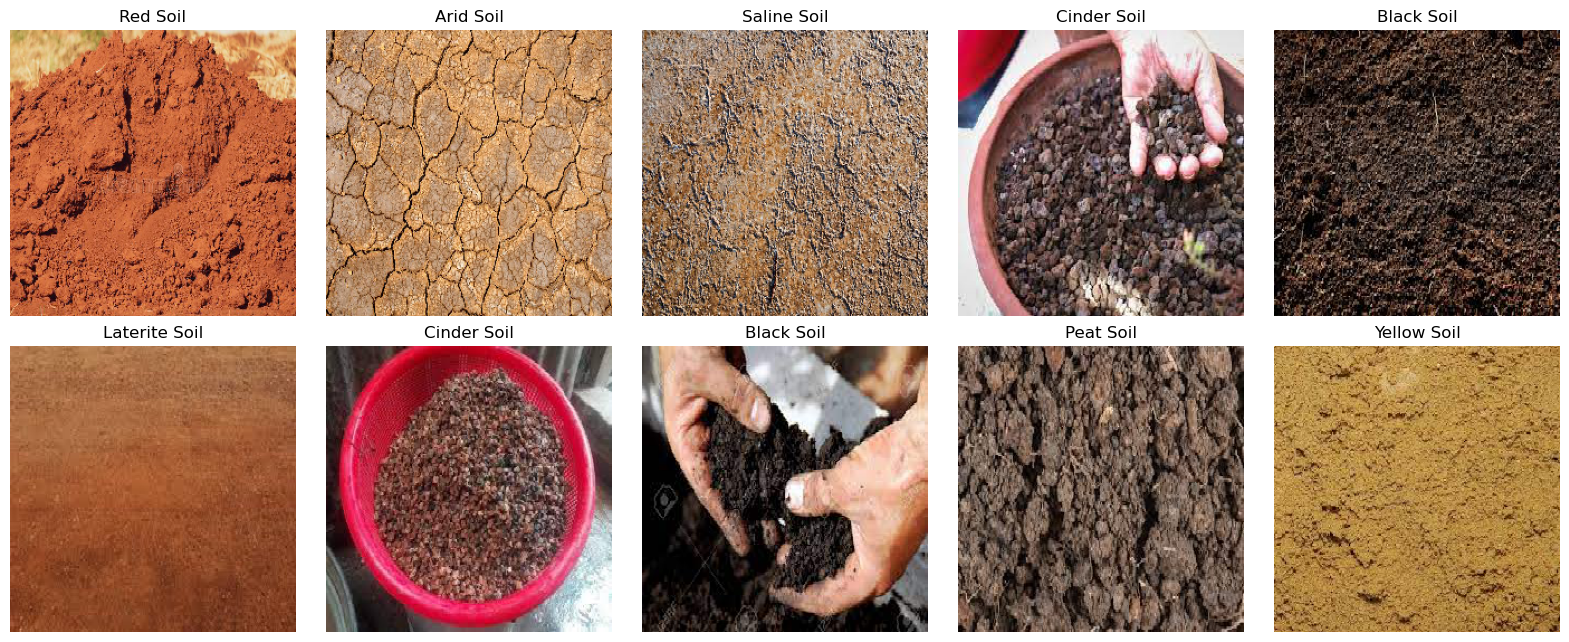

In [179]:

show_grid(x,2,5,label_list=y_int,show_labels=True,figsize=(20,10))

# Testing Model to find optimal epochs

In [180]:
total_sample = train_generator.n
n_epochs = 50

In [181]:
model = tf.keras.models.Sequential([
    
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The third convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fourth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # x output neurons for x classes with the softmax activation
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])


history = model.fit(
        train_generator, 
        steps_per_epoch = int(total_sample/batch_size),  
        epochs = n_epochs,
        verbose = 1)

Epoch 1/50


2022-11-16 10:41:47.457526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 50ms/step - loss: 11.8866 - acc: 0.2434
Epoch 2/50
19/19 [==============================] - 1s 41ms/step - loss: 1.5681 - acc: 0.4339
Epoch 3/50
19/19 [==============================] - 1s 41ms/step - loss: 0.9491 - acc: 0.7143
Epoch 4/50
19/19 [==============================] - 1s 39ms/step - loss: 0.9516 - acc: 0.7196
Epoch 5/50
19/19 [==============================] - 1s 39ms/step - loss: 0.4443 - acc: 0.8889
Epoch 6/50
19/19 [==============================] - 1s 39ms/step - loss: 0.3633 - acc: 0.8836
Epoch 7/50
19/19 [==============================] - 1s 42ms/step - loss: 0.2846 - acc: 0.9206
Epoch 8/50
19/19 [==============================] - 1s 41ms/step - loss: 0.5724 - acc: 0.9048
Epoch 9/50
19/19 [==============================] - 1s 37ms/step - loss: 0.1669 - acc: 0.9577
Epoch 10/50
19/19 [==============================] - 1s 37ms/step - loss: 0.2786 - acc: 0.9418
Epoch 11/50
19/19 [==============================] - 1s 39ms/step - l

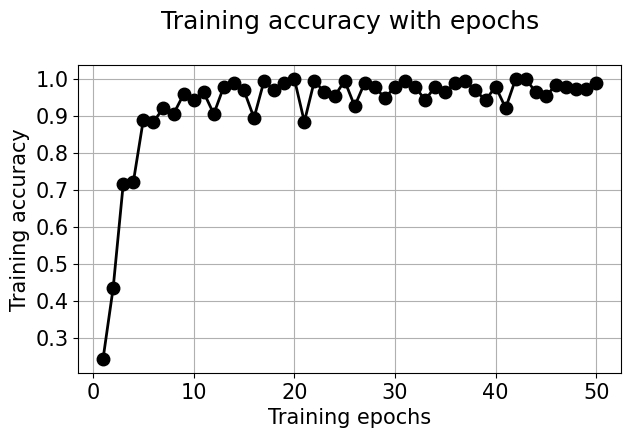

In [182]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['acc'],'-o',c='k',lw=2,markersize=9)
plt.grid(1)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

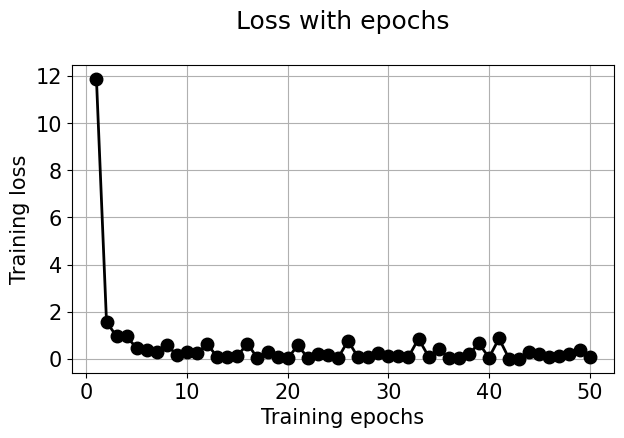

In [183]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['loss'],'-o',c='k',lw=2,markersize=9)
plt.grid(1)
plt.title("Loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

As Seen from the Accuracy and Loss Graphs, to avoid overfitting, ideal number of epochs is around 15

In [225]:
total_sample = train_generator.n
n_epochs = 11

In [226]:
model = tf.keras.models.Sequential([
    
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The third convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fourth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # x output neurons for x classes with the softmax activation
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])


history = model.fit(
        train_generator, 
        steps_per_epoch = int(total_sample/batch_size),  
        epochs = n_epochs,
        verbose = 1)

Epoch 1/11


2022-11-16 10:46:16.267945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 57ms/step - loss: 10.7758 - acc: 0.2169
Epoch 2/11
19/19 [==============================] - 1s 43ms/step - loss: 1.5169 - acc: 0.3757
Epoch 3/11
19/19 [==============================] - 1s 44ms/step - loss: 1.2430 - acc: 0.6190
Epoch 4/11
19/19 [==============================] - 1s 43ms/step - loss: 0.9646 - acc: 0.7460
Epoch 5/11
19/19 [==============================] - 1s 41ms/step - loss: 0.6843 - acc: 0.8307
Epoch 6/11
19/19 [==============================] - 1s 38ms/step - loss: 0.4846 - acc: 0.8783
Epoch 7/11
19/19 [==============================] - 1s 39ms/step - loss: 0.4311 - acc: 0.8571
Epoch 8/11
19/19 [==============================] - 1s 41ms/step - loss: 0.1549 - acc: 0.9630
Epoch 9/11
19/19 [==============================] - 1s 39ms/step - loss: 0.4162 - acc: 0.8889
Epoch 10/11
19/19 [==============================] - 1s 38ms/step - loss: 0.0682 - acc: 0.9841
Epoch 11/11
19/19 [==============================] - 1s 40ms/step - l

# Testing Model with Prediction

In [227]:
y_prob = model.predict(validation_generator)
y_prob

2022-11-16 10:46:25.847943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[1.51770907e-02, 2.02584686e-03, 1.34476386e-02, 4.71870482e-01,
        1.41526572e-03, 4.83179808e-01, 1.57001152e-04, 1.27268974e-02],
       [3.46218958e-03, 2.92326586e-05, 1.63787361e-02, 1.31530100e-02,
        1.89825341e-01, 3.52486750e-05, 6.94930375e-01, 8.21859017e-02],
       [1.44261077e-01, 3.00550181e-03, 2.73953956e-02, 3.76111507e-01,
        1.09148165e-02, 1.07404046e-01, 8.36707361e-04, 3.30071002e-01],
       [1.77014642e-03, 1.54112443e-01, 6.11350000e-01, 1.26420893e-03,
        1.14216805e-01, 4.12909896e-04, 8.77169445e-02, 2.91564986e-02],
       [7.18177122e-04, 9.29756820e-01, 2.44864039e-02, 7.90349615e-04,
        3.35409418e-02, 9.49938782e-04, 2.07114499e-03, 7.68620567e-03],
       [5.98954684e-05, 9.10094082e-01, 5.78167029e-02, 1.36771778e-04,
        2.44015045e-02, 8.66363116e-05, 1.90686586e-03, 5.49752172e-03],
       [1.14409355e-04, 9.73590672e-01, 7.57592311e-03, 1.68326296e-04,
        1.51271718e-02, 2.02198149e-04, 4.22563462e-04, 2.

In [228]:
y_pred = y_prob.argmax(axis=1)
print(y_pred)
print(len(y_pred))

[5 6 3 2 1 1 1 1 2 2 2 2 3 3 3 3 2 3 1 4 3 5 5 5 6 3 6 7 7 7 7]
31


In [229]:
number_of_examples = len(validation_generator.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

y_test = []

for i in range(0,int(number_of_generator_calls)):
    y_test.extend(np.argmax(np.array(validation_generator[i][1]),axis=-1))

print(y_test)
print(len(y_test))

[0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7]
31


In [230]:
correct=0
for i in range(len(y_test)):
    if y_pred[i]==y_test[i]:
        correct+=1
print("Validation Accuracy=",correct/len(y_test))

Validation Accuracy= 0.7096774193548387


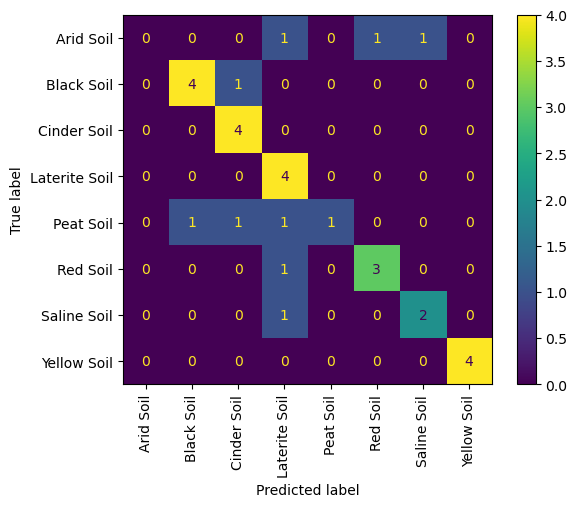

In [231]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(validation_generator.class_indices.keys()))
disp.plot()
plt.xticks(rotation = 90)
plt.show()

# Saving the Model

The saved model formats can be used to continue with the model preparation without actually starting from the beginning.<br>
The saved model files can be used to deploy the model in android or web applications.

In [232]:
#model.save('my_model.h5')

In [233]:
# pickle_out = open("CNN_model.pickle","wb")
# pickle.dump(model, pickle_out)
# pickle_out.close()